In [5]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [7]:
stock = 'AAPL'

In [23]:
#get data on this ticker
tickerData = yf.Ticker(stock)
#get the historical prices for this ticker
tickerDf = tickerData.history(interval='1d', start='2025-1-1', end='2025-4-10')
priceData = tickerDf.Close

In [25]:
priceData = priceData.asfreq(pd.infer_freq(priceData.index))
priceData

Date
2025-01-02 00:00:00-05:00    243.582199
2025-01-03 00:00:00-05:00    243.092728
2025-01-04 00:00:00-05:00           NaN
2025-01-05 00:00:00-05:00           NaN
2025-01-06 00:00:00-05:00    244.730927
                                ...    
2025-04-05 00:00:00-04:00           NaN
2025-04-06 00:00:00-04:00           NaN
2025-04-07 00:00:00-04:00    181.460007
2025-04-08 00:00:00-04:00    172.419998
2025-04-09 00:00:00-04:00    198.850006
Freq: D, Name: Close, Length: 98, dtype: float64

In [27]:
priceData = priceData.ffill()
priceData.isna().sum()

0

Text(0.5, 1.0, 'AAPL Price Data')

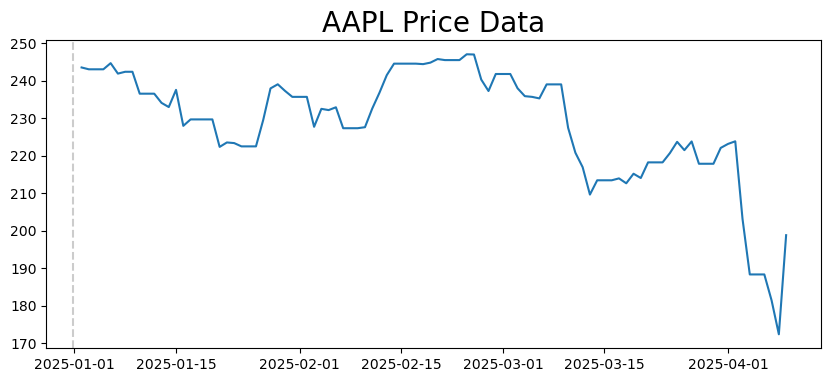

In [29]:
plt.figure(figsize=(10,4))
plt.plot(priceData)
for year in range(priceData.index[0].year, priceData.index[-1].year+1):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.2)
plt.title("%s Price Data"%stock, fontsize=20)

Basic Buying Protocol:
- Buy if stock increasing for n consecutive days
Basic Selling Protocols:
- Sell if stock decreasing for m consecutive days (and we've made a profit)

In [41]:
def simple_trading_strategy(stock, buy, sell):
    pct_change = stock.pct_change()[1:]
    #buying function
    def buy_stock(sub_series):
        return (sub_series > 0).all()
    #selling function
    def sell_stock(sub_series):
        return (sub_series<0).all()
    #get all buying days in the data
    buying_days = pct_change.rolling(buy).apply(buy_stock)
    
    #get all potential selling days in the data
    potential_selling_days = pct_change.rolling(sell).apply(sell_stock)
    #return a dictionary
    return {'buying_days': buying_days, 'potential_selling_days': potential_selling_days}

In [154]:
d = simple_trading_strategy(priceData,3,2)
buying_days = d['buying_days']
selling_days = d['potential_selling_days']

In [156]:
df_stock = pd.DataFrame(index = buying_days.index)
df_stock['buying_days'] = (buying_days==1)
df_stock['selling_days'] = (selling_days == 1)
df_stock['price'] = priceData

In [158]:
#only keep days that are buying or possible selling days
df_stocks = df_stock[(df_stock.buying_days | df_stock.selling_days)]

In [160]:
def check_cumulative_percent_change(price_data, buy_date, potential_sell_date):
    """
    This helper function will check if the cumulative percent change
    between a buying and potential selling day yields overall growth
    """
    
    #get the percent change day after day
    pct_change = price_data.pct_change()[1:]
    
    sub_series = 1 + pct_change[buy_date + timedelta(hours=1): potential_sell_date]

    return sub_series.product() > 1

In [162]:
def get_investing_result(df_stocks, starting_funds, verbose=False):
    
    #get a copy of price data
    price_data = df_stocks.price
    
    #at start, not holding any shares
    holding = False
    
    #init vars
    current_funds = starting_funds
    current_shares = 0
    last_buy_date = None
    
    #init dict of buying and selling dates
    events_list = []
    
    #for each buying day and potential selling day...
    for date,data in df_stocks.iterrows():
        
        #if not currently holding shares, and this is a buying day...
        if (not holding) and data.buying_days:
            
            #calculate the number of shares we can buy
            num_shares_to_buy = int(current_funds / data.price)
            
            #update number of shares
            current_shares += num_shares_to_buy
            
            #decrease current funds
            current_funds -= num_shares_to_buy * data.price
            
            #set last buy date
            last_buy_date = date
            events_list.append(('b', date))
            
            #we are now holding shares
            holding = True
            
            if verbose:
                print('Bought %s shares at $%s on %s totaling $%s'%(num_shares_to_buy, data.price, date.date(), round(num_shares_to_buy*data.price,2)))
        
        #if you are holding shares, and this is a potential selling day...
        elif holding and data.selling_days:
            
            #check to make sure we're making a profit
            if check_cumulative_percent_change(price_data, last_buy_date, date):
                #add to our current funds
                current_funds += current_shares * data.price
                
                if verbose:
                    print('Sold %s shares at $%s on %s totaling $%s'%(current_shares, data.price, date.date(), round(num_shares_to_buy*data.price,2)))
                    print('--------------------------------------')
                    
                #reset current shares
                current_shares = 0
                
                #we are no longer holding shares
                holding = False
                
                events_list.append(('s', date))
                
    #get the stock price at the end of the time span
    final_stock_price = price_data.iloc[-1]
        
    #get the final total value of all assets (funds + stock value)
    final_value = current_funds + final_stock_price * current_shares
    
    #return the percent change in value
    return round((final_value - starting_funds) / starting_funds,2), events_list

In [170]:
percent_change, events_list = get_investing_result(df_stocks, 10000, True)
print(percent_change*100)

Bought 41 shares at $239.0971221923828 on 2025-01-29 totaling $9802.98
Sold 41 shares at $240.36000061035156 on 2025-02-26 totaling $9854.76
--------------------------------------
Bought 44 shares at $223.88999938964844 on 2025-04-02 totaling $9851.16
-22.0


(163.0, 259.0)

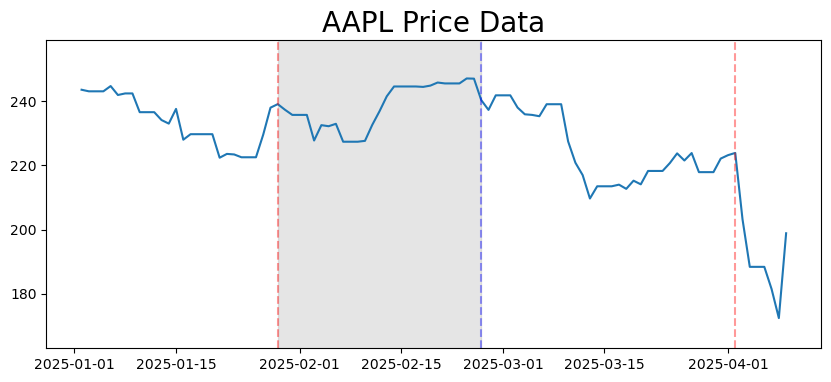

In [172]:
plt.figure(figsize=(10,4))
plt.plot(priceData)

y_lims = (int(priceData.min()*.95), int(priceData.max()*1.05))
shaded_y_lims = int(priceData.min()*.5), int(priceData.max()*1.5)

for idx, event in enumerate(events_list):
    color = 'red' if event[0] == 'b' else 'blue'
    plt.axvline(event[1], color=color, linestyle='--', alpha=0.4)
    if event[0] == 's':
        plt.fill_betweenx(range(*shaded_y_lims), 
                          event[1], events_list[idx-1][1], color='k', alpha=0.1)

plt.title("%s Price Data"%stock, fontsize=20)
plt.ylim(*y_lims)